Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 930 files belonging to 2 classes.
Using 744 files for training.
Found 930 files belonging to 2 classes.
Using 186 files for validation.
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5642 - loss: 1.4184 - val_accuracy: 0.6237 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.6822 - loss: 0.6804 - val_accuracy: 0.6398 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.7090 - loss: 0.6090 - val_accuracy: 0.5000 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.6791 - loss: 0.6700 - val_accuracy: 0.5591 - val_loss: 0.6448 - learning_rate: 0.0010
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.6965 - loss: 0.6324 - val_accuracy: 0.5591 - val_loss: 

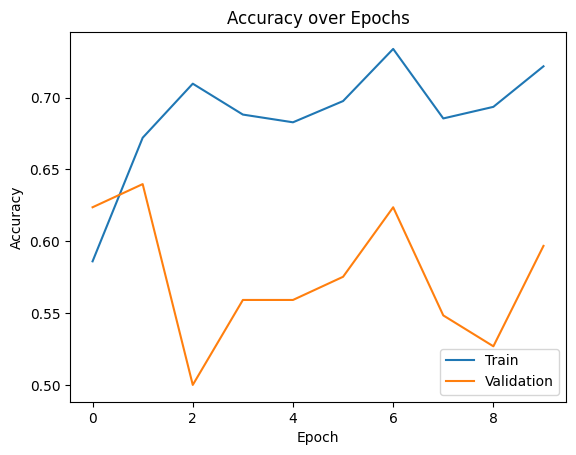

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6391 - loss: 0.5545
Test Loss: 0.5797156095504761
Test Accuracy: 0.6236559152603149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step

Calculated Accuracy: 0.6237
Macro F1 Score: 0.5991
Precision: 0.7149
Recall: 0.6459
AUROC: 0.8747


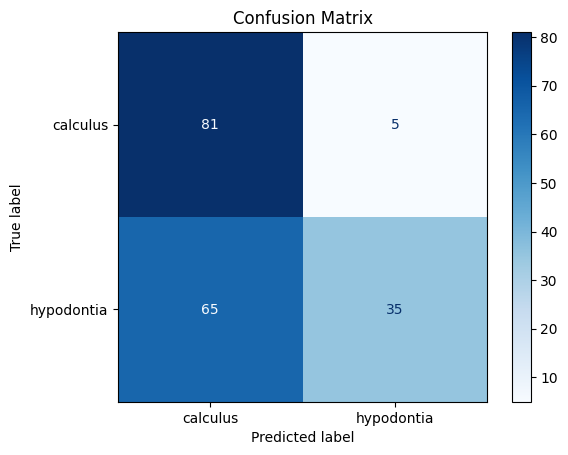

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary packages
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Set parameters
batch_size = 32
img_height, img_width = 32, 32
dataset_dir = '/content/drive/MyDrive/original_data'

# Load dataset
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="training", seed=123,
    image_size=(img_height, img_width), batch_size=batch_size
)
raw_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="validation", seed=123,
    image_size=(img_height, img_width), batch_size=batch_size
)
class_names = raw_train_dataset.class_names

# Apply label noise (optional: reduce noise for better performance)
def add_label_noise(x, y, noise_factor=0.4):
    noise = tf.random.uniform(tf.shape(y), 0, 1)
    random_labels = tf.random.uniform(tf.shape(y), 0, 2, dtype=tf.int64)
    noisy_y = tf.where(noise < noise_factor, random_labels, tf.cast(y, tf.int64))
    return x / 255.0, noisy_y

train_dataset = raw_train_dataset.map(lambda x, y: add_label_noise(x, y))
test_dataset = raw_test_dataset.map(lambda x, y: (x / 255.0, y))

# Define a regularized CNN model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2)  # Logits output
])

# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# Train the model for 10 epochs
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10, callbacks=callbacks)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Calculate full classification metrics
all_labels, all_preds, all_probs = [], [], []
for images, labels in test_dataset:
    logits = model.predict(images)
    probs = tf.nn.softmax(logits, axis=1).numpy()
    preds = np.argmax(probs, axis=1)
    all_labels.extend(labels.numpy())
    all_preds.extend(preds)
    all_probs.extend(probs)

all_labels, all_preds, all_probs = np.array(all_labels), np.array(all_preds), np.array(all_probs)
accuracy_val = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
precision_val = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_val = recall_score(all_labels, all_preds, average='macro')
auroc_val = roc_auc_score(all_labels, all_probs[:, 1])

print(f"\nCalculated Accuracy: {accuracy_val:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"AUROC: {auroc_val:.4f}")

# Display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
